<a href="https://colab.research.google.com/github/PatricRc/PatricRc/blob/main/Kaggle_titanic_datascience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cargar datos

In [1]:
### Cargar datos
import pandas as pd
from pandas_profiling import ProfileReport

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [4]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [ ]:
df.info()

In [ ]:
profile = ProfileReport(df, title='Spaceship Titanic')

In [ ]:
profile.to_notebook_iframe()

In [ ]:
df.isnull().sum()

In [8]:
def split_cabin(x):
  if len(str(x).split('/')) < 3:
    return ['Missing','Missing','Missing']
  else:
    return str(x).split('/')

In [9]:
def preprocessing(df):
  df['HomePlanet'].fillna('Missing', inplace=True)
  df['TempCabin'] = df['Cabin'].apply(lambda x: split_cabin(x))
  df['Deck'] = df['TempCabin'].apply(lambda x: x[0])
  df['Side'] = df['TempCabin'].apply(lambda x: x[2])
  df.drop('TempCabin', axis = 1, inplace=True)
  df['Destination'].fillna('Missing', inplace=True)
  df['Age'] = df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['RoomService'].fillna(0, inplace=True)
  df['FoodCourt'].fillna(0, inplace=True)
  df['ShoppingMall'].fillna(0, inplace=True)
  df['Spa'].fillna(0, inplace=True)
  df['VRDeck'].fillna(0, inplace=True)
  df.drop('Name', axis=1,inplace=True)
  df['CryoSleep'].fillna('Missing', inplace=True)
  df['VIP'].fillna('Missing', inplace=True)

In [10]:
abt = df.copy()

In [11]:
preprocessing(abt)

In [12]:
abt.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,None,False,0.0,0.0,0.0,0.0,0.0,False,B,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,None,False,109.0,9.0,25.0,549.0,44.0,True,F,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,None,True,43.0,3576.0,0.0,6715.0,49.0,False,A,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,None,False,0.0,1283.0,371.0,3329.0,193.0,False,A,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,None,False,303.0,70.0,151.0,565.0,2.0,True,F,S


In [13]:
abt.isnull().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin            199
Destination        0
Age             8693
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported        0
Deck               0
Side               0
dtype: int64



1.   Seleccinar base X, y
2.   One Hot encoding
3.   Train, holdout split
4.   Train on bunch of algos



In [14]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [15]:
X = abt.drop(['Transported','PassengerId'], axis=1)
X = pd.get_dummies(X)
y = abt['Transported']

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234) 

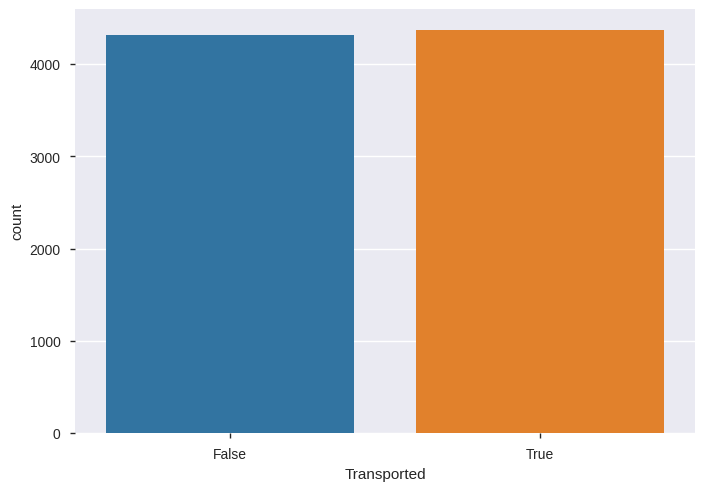

In [17]:
sns.countplot(x='Transported', data=df)

In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [19]:
pipelines = {
    'rf': make_pipeline(StandardScaler(),RandomForestClassifier(random_state=1234)),
    'gb': make_pipeline(StandardScaler(),GradientBoostingClassifier(random_state=1234))
}

In [ ]:
GradientBoostingClassifier().get_params()

In [21]:
grid = {
    'rf': {
        'randomforestclassifier__n_estimators':[100,200,300]
    },
    'gb': {
        'gradientboostingclassifier__n_estimators':[100,200,300]
    }
}

In [24]:
fit_models = {}
for algo, pipeline in pipelines.items():
  print(f'Training the {algo} model.')
  model = GridSearchCV(pipeline, grid[algo], cv=10)
  model.fit(x_train, y_train)
  fit_models[algo] = model

Training the rf model.
Training the gb model.


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [25]:
for algo, model  in fit_models.items():
  yhat = model.predict(x_test)
  accuracy = accuracy_score(y_test, yhat)
  precision = precision_score(y_test, yhat)
  recall = recall_score(y_test, yhat)
  print(f'Metrics for {algo}: accuracy- {accuracy}, recall- {recall}, precision- {precision}')

Metrics for rf: accuracy- 0.7967791411042945, recall- 0.779320987654321, precision- 0.8054226475279107
Metrics for gb: accuracy- 0.7975460122699386, recall- 0.8433641975308642, precision- 0.7708039492242595


In [23]:
import pickle

In [26]:
with open('gradientboosted.pkl', 'wb') as f:
  pickle.dump(fit_models['gb'], f)

In [27]:
with open('gradientboosted.pkl', 'rb') as f:
  reloaded_model = pickle.load(f)

In [29]:
test_df = pd.read_csv('test.csv')
abt_test = test_df.copy()
preprocessing(abt_test)
abt_test = pd.get_dummies(abt_test.drop('PassengerId', axis=1))

In [ ]:
yhat_test = fit_models['gb'].predict(abt_test)

In [ ]:
submission = pd.DataFrame([test_df['PassengerId'], yhat_test]).T

In [ ]:
submission.to_csv('kaggle_submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c spaceship-titanic -m 'initial gb model' -f 'kaggle_submissions.csv'